# G2M Strategy for the Cab Industry

Business Problem:

To decide between Pink Cab and Yellow Cab, which company is more investable, and if the cab industry as a whole is a worthwhile investment.

Questions to Answer: 
1. Is there a correlation between KM travelled and the profit of the trip?
2. Is the cab industry growing at a fast enough rate to beat inflation?
3. Do the businesses make a high enough profit margin to remain profitable?
4. Are the businesses scalable?
5. Do these businesses retain repeat customers?

Assumptions
-	We assume that  only the cities listed in the transactions are where the businesses operate (more cities would change the number of profit/trips and therefore the whole strategy)
-	We assume that the number of users listed in ‘City.csv’ includes other cab services apart from Pink and Yellow. 
-	We assume that profit is the price charged minus the cost of the trip (without calculating any extra overheads such as fuel cost, wages, depreciation of the car); these factors might be accounted for within the cost of the trip. 
-	We assume the data is otherwise entered correctly. 
-	We cannot remove outliers from prices charged because there is no data on the duration of the trip, i.e., the price is totally dependent on the distance travelled where in reality there is often a flat fee for time spent waiting.


Considerations not taken into account explicitly: 
- Age and gender demographics (although this can show scalability, there is little reason how cab services can affect the demographic they cater to)
- Seasonality in performance (averaged out in yearly statistics)



## Imports and DataFrames 
Duplicate removal and check for Null entries.

In [199]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from IPython.display import HTML
import datetime as dt
import scipy.stats as stats

# formatting function for millions in graphs
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

In [200]:
# city dataframe
city_df = pd.read_csv('city.csv', thousands = ',')
city_df.drop_duplicates(inplace = True)
print(city_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        20 non-null     object
 1   Population  20 non-null     int64 
 2   Users       20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 608.0+ bytes
None


In [201]:
# cab dataframe
cab_df = pd.read_csv('cab.csv', )
cab_df.drop_duplicates(inplace = True)
cab_df['Date of Travel'] = pd.to_datetime(cab_df['Date of Travel'], format = '%m/%d/%y')
print(cab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Transaction ID  359392 non-null  int64         
 1   Date of Travel  359392 non-null  datetime64[ns]
 2   Company         359392 non-null  object        
 3   City            359392 non-null  object        
 4   KM Travelled    359392 non-null  float64       
 5   Price Charged   359392 non-null  float64       
 6   Cost of Trip    359392 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 19.2+ MB
None


In [202]:
# customer dataframe
cust_df = pd.read_csv('customer.csv')
cust_df.drop_duplicates(inplace = True)
print(cust_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


In [203]:
# transaction dataframe
trans_df = pd.read_csv('transaction.csv')
trans_df.drop_duplicates(inplace = True)
print(trans_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB
None


## Descriptive Analysis of Trips and Profits

,count
Company,
Yellow Cab,82239
Pink Cab,25080


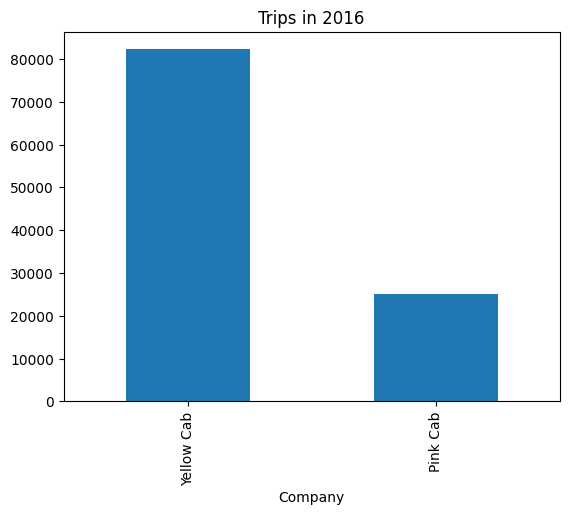

In [204]:
# Create new feature from price charged - cost of trip (i.e., profit per trip)
cab_df['Profit'] = cab_df['Price Charged'] - cab_df['Cost of Trip']

# Trips every year for both services
cab_df.loc[cab_df['Date of Travel'].dt.year == 2016]['Company'].value_counts().plot(kind="bar", title="Trips in 2016")
cab_df.loc[cab_df['Date of Travel'].dt.year == 2016]['Company'].value_counts().to_frame()

,count
Company,
Yellow Cab,98189
Pink Cab,30321


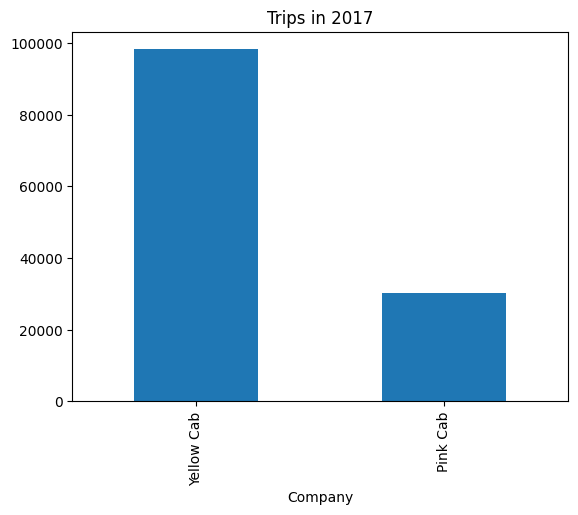

In [205]:
cab_df.loc[cab_df['Date of Travel'].dt.year == 2017]['Company'].value_counts().plot(kind="bar", title="Trips in 2017")
cab_df.loc[cab_df['Date of Travel'].dt.year == 2017]['Company'].value_counts().to_frame()

,count
Company,
Yellow Cab,94253
Pink Cab,29310


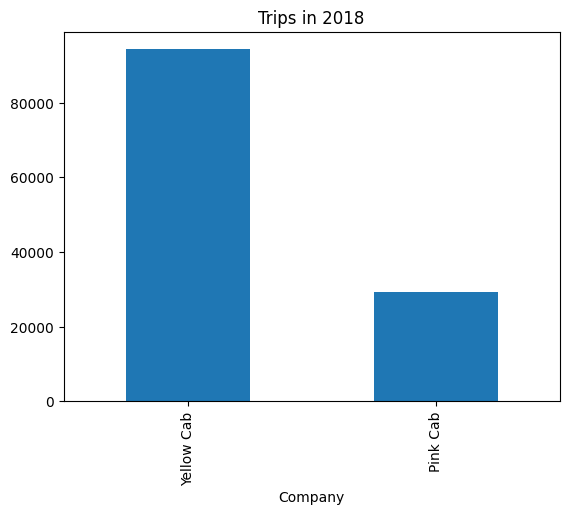

In [206]:
cab_df.loc[cab_df['Date of Travel'].dt.year == 2018]['Company'].value_counts().plot(kind="bar", title="Trips in 2018")
cab_df.loc[cab_df['Date of Travel'].dt.year == 2018]['Company'].value_counts().to_frame()

### Yearly Trips

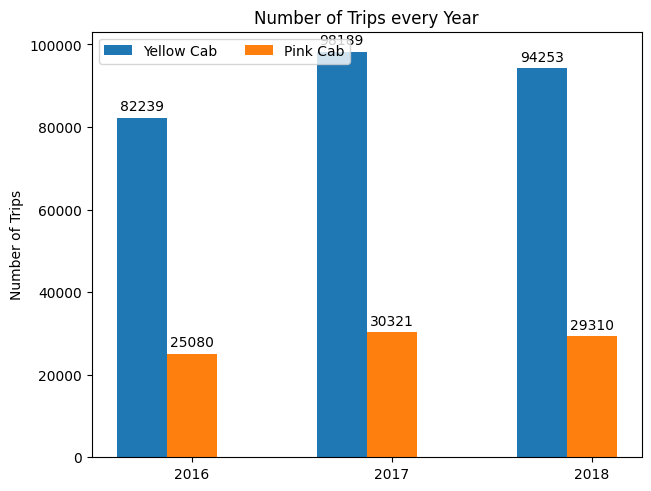

In [207]:

years = ['2016','2017','2018']
trips_yearly = {
    'Yellow Cab': (82239, 98189, 94253),
    'Pink Cab': (25080, 30321, 29310),
}

x = np.arange(len(years))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in trips_yearly.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Trips')
ax.set_title('Number of Trips every Year')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=3)

plt.show()

# Suggests Pink Cab might be more scalable

### Yellow Cab Data

In [208]:
# profit
yellow_profit_2016 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2016), 'Profit'].sum()
yellow_profit_2017 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2017), 'Profit'].sum()
yellow_profit_2018 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2018), 'Profit'].sum()

# km travelled
yellow_km_2016 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2016), 'KM Travelled'].sum()
yellow_km_2017 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2017), 'KM Travelled'].sum()
yellow_km_2018 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2018), 'KM Travelled'].sum()

# expenses
yellow_expenses_2016 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2016), 'Cost of Trip'].sum()
yellow_expenses_2017 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2017), 'Cost of Trip'].sum()
yellow_expenses_2018 = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Date of Travel'].dt.year == 2018), 'Cost of Trip'].sum()



# data frame for financial data
yellow_df = pd.DataFrame({'total_profit': [yellow_profit_2016, yellow_profit_2017, yellow_profit_2018], 'total_km': [yellow_km_2016, yellow_km_2017, yellow_km_2018], 'total_expenses': [yellow_expenses_2016, yellow_expenses_2017, yellow_expenses_2018]}, index = [2016, 2017, 2018])
yellow_df['profit_per_km'] = (yellow_df['total_profit'] / yellow_df['total_km']).round(2)
yellow_df['profit_margin'] = ((yellow_df['total_profit'] / yellow_df['total_expenses']) * 100).round(3)
print(yellow_df)


      total_profit    total_km  total_expenses  profit_per_km  profit_margin
2016  1.392700e+07  1859978.21    2.455414e+07           7.49         56.720
2017  1.657598e+07  2214879.02    2.924293e+07           7.48         56.684
2018  1.351740e+07  2124560.24    2.803644e+07           6.36         48.214


### Pink Cat Data

In [209]:
# profit
pink_profit_2016 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2016), 'Profit'].sum()
pink_profit_2017 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2017), 'Profit'].sum()
pink_profit_2018 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2018), 'Profit'].sum()

# km travelled 
pink_km_2016 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2016), 'KM Travelled'].sum()
pink_km_2017 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2017), 'KM Travelled'].sum()
pink_km_2018 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2018), 'KM Travelled'].sum()

# expenses
pink_expenses_2016 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2016), 'Cost of Trip'].sum()
pink_expenses_2017 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2017), 'Cost of Trip'].sum()
pink_expenses_2018 = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Date of Travel'].dt.year == 2018), 'Cost of Trip'].sum()

# data frame for financial data
pink_df = pd.DataFrame({'total_profit': [pink_profit_2016, pink_profit_2017, pink_profit_2018], 'total_km': [pink_km_2016, pink_km_2017, pink_km_2018], 'total_expenses': [pink_expenses_2016, pink_expenses_2017, pink_expenses_2018]}, index = [2016, 2017, 2018])
pink_df['profit_per_km'] = (pink_df['total_profit'] / pink_df['total_km']).round(2)
pink_df['profit_margin'] = ((pink_df['total_profit'] / pink_df['total_expenses']) * 100).round(3)
print(pink_df)

      total_profit   total_km  total_expenses  profit_per_km  profit_margin
2016   1713511.224  563509.67     6194968.006           3.04         27.660
2017   2033654.908  685823.52     7544974.632           2.97         26.954
2018   1560162.189  661739.92     7280980.371           2.36         21.428


### Profit Per Year

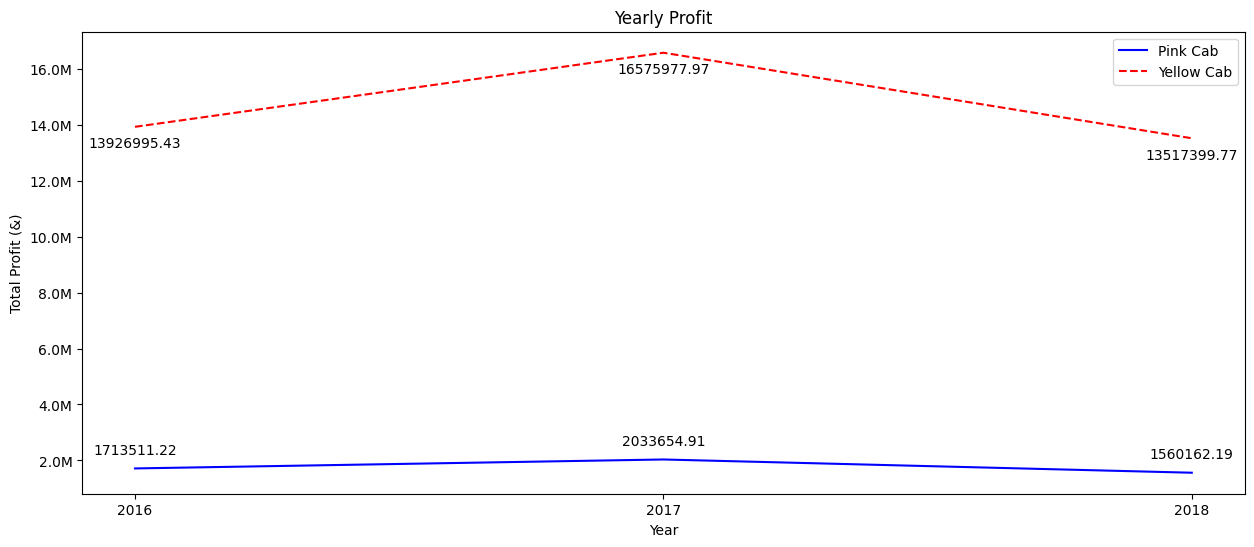

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

# plot data
plt.plot(pink_df['total_profit'], linestyle='-', color='b', label='Pink Cab')
plt.plot(yellow_df['total_profit'], linestyle='--', color='r', label='Yellow Cab')


# add title and axis labels
plt.title('Yearly Profit')
plt.xlabel('Year')
plt.ylabel('Total Profit (&)')
plt.legend()

plt.xticks([2016, 2017, 2018])
ax.yaxis.set_major_formatter(millions)

# add labels to points
for x,y in zip([2016, 2017, 2018], pink_df['total_profit']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
for x,y in zip([2016, 2017, 2018], yellow_df['total_profit']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent

plt.show()

### Profit/KM Per Year
(This should standardise for the comapny sizes and number of trips)

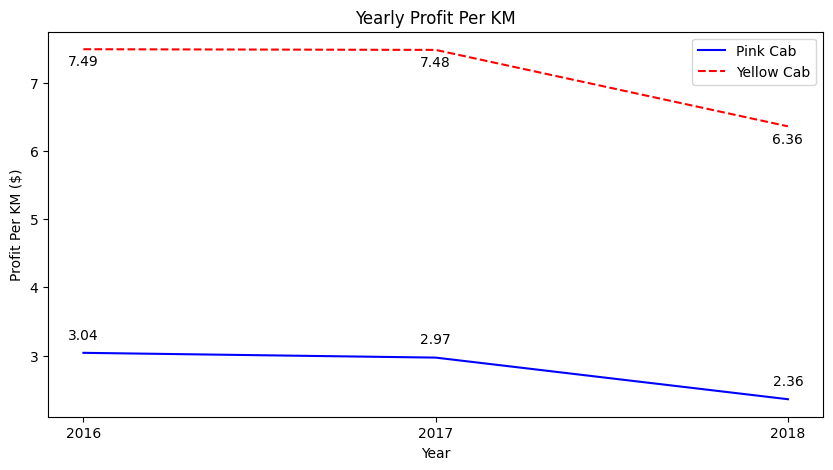

In [211]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
# plot data
plt.plot(pink_df['profit_per_km'], linestyle='-', color='b', label='Pink Cab')
plt.plot(yellow_df['profit_per_km'], linestyle='--', color='r', label='Yellow Cab')


# add title and axis labels
plt.title('Yearly Profit Per KM')
plt.xlabel('Year')
plt.ylabel('Profit Per KM ($)')
plt.legend()

plt.xticks([2016, 2017, 2018])

# add labels to points
for x,y in zip([2016, 2017, 2018], pink_df['profit_per_km']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
for x,y in zip([2016, 2017, 2018], yellow_df['profit_per_km']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-12), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent

plt.show()

### Profit Margins

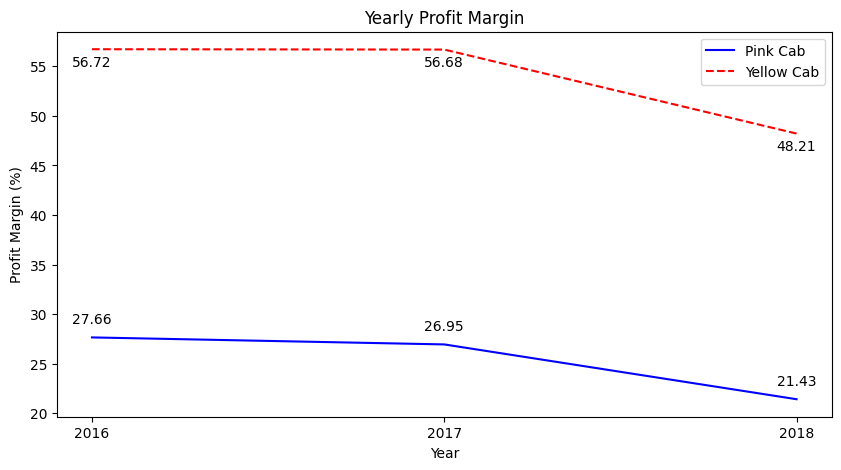

In [212]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
# plot data
plt.plot(pink_df['profit_margin'], linestyle='-', color='b', label='Pink Cab')
plt.plot(yellow_df['profit_margin'], linestyle='--', color='r', label='Yellow Cab')


# add title and axis labels
plt.title('Yearly Profit Margin')
plt.xlabel('Year')
plt.ylabel('Profit Margin (%)')
plt.legend()

plt.xticks([2016, 2017, 2018])

# add labels to points
for x,y in zip([2016, 2017, 2018], pink_df['profit_margin']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
for x,y in zip([2016, 2017, 2018], yellow_df['profit_margin']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-12), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent

plt.show()

### Expenses

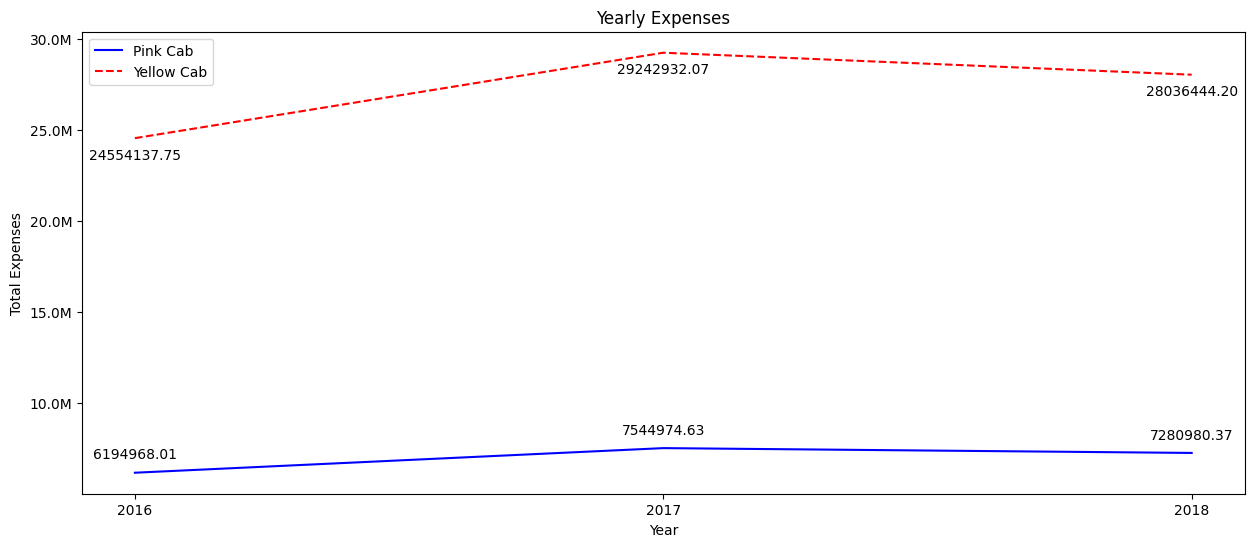

In [213]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

# plot data
plt.plot(pink_df['total_expenses'], linestyle='-', color='b', label='Pink Cab')
plt.plot(yellow_df['total_expenses'], linestyle='--', color='r', label='Yellow Cab')


# add title and axis labels
plt.title('Yearly Expenses')
plt.xlabel('Year')
plt.ylabel('Total Expenses')
plt.legend()

plt.xticks([2016, 2017, 2018])
ax.yaxis.set_major_formatter(millions)

# add labels to points
for x,y in zip([2016, 2017, 2018], pink_df['total_expenses']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
for x,y in zip([2016, 2017, 2018], yellow_df['total_expenses']): 
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent

plt.show()

## Profitability

In [214]:
cab_df.loc[(cab_df['Date of Travel'].dt.year == 2016) & (cab_df)['Profit'] > 0]['Company'].value_counts() - cab_df.loc[(cab_df['Date of Travel'].dt.year == 2016)]['Company'].value_counts()

Company
Yellow Cab   -1
Pink Cab      0
Name: count, dtype: int64

In [215]:
cab_df.loc[(cab_df['Date of Travel'].dt.year == 2017) & (cab_df)['Profit'] > 0]['Company'].value_counts() - cab_df.loc[(cab_df['Date of Travel'].dt.year == 2017)]['Company'].value_counts()

Company
Yellow Cab    0
Pink Cab     -1
Name: count, dtype: int64

In [216]:
cab_df.loc[(cab_df['Date of Travel'].dt.year == 2018) & (cab_df)['Profit'] > 0]['Company'].value_counts() - cab_df.loc[(cab_df['Date of Travel'].dt.year == 2018)]['Company'].value_counts()

Company
Yellow Cab   -1
Pink Cab     -1
Name: count, dtype: int64

## Marketshare

City,Pct Users
SAN FRANCISCO CA,33.928
BOSTON MA,32.141
WASHINGTON DC,30.321
LOS ANGELES CA,9.036
CHICAGO IL,8.412
SAN DIEGO CA,7.296
SEATTLE WA,3.734
NEW YORK NY,3.595
ATLANTA GA,3.031
NASHVILLE TN,2.833


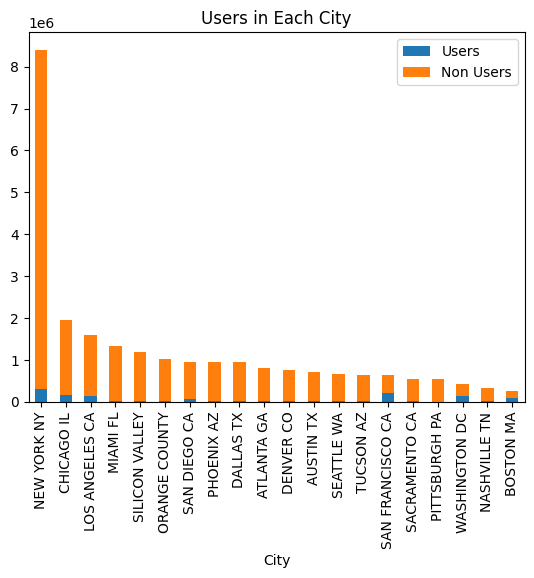

In [217]:
# Create new features in city dataframe
city_df['Pct Users'] = ((city_df['Users'] / city_df['Population']) * 100).round(3)
city_df['Non Users'] = city_df['Population'] - city_df['Users']

city_df.plot.bar(x = 'City',stacked = 'True', y = ['Users', 'Non Users'], title = 'Users in Each City'  )
HTML(city_df.sort_values(by=['Pct Users'], ascending=False).to_html(index=False, columns = ['City', 'Pct Users']))

# print(city_df)

In [218]:
# Join Transaction IDs since they are primary and relational keys. 
cabtrans_df = cab_df.join(trans_df, lsuffix='_cab', rsuffix='_other')
cabtrans_df['Transaction ID_other'].notnull().sum() == cabtrans_df.shape[0]
# All joined values are not null

True

## Univariate Analysis of Profits

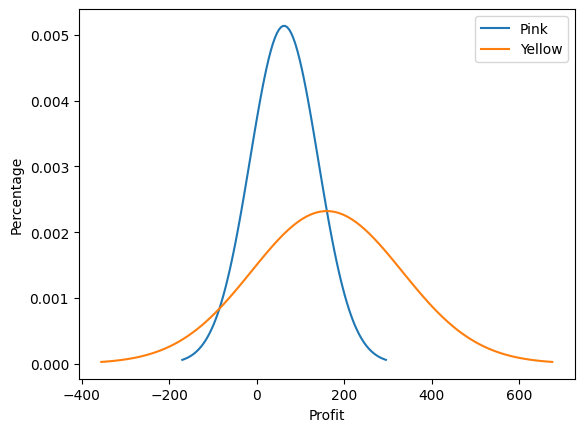

In [219]:
yellow_mu = cab_df.loc[cab_df['Company'] == 'Yellow Cab']['Profit'].mean()
yellow_sigma = cab_df.loc[cab_df['Company'] == 'Yellow Cab']['Profit'].std()
pink_mu = cab_df.loc[cab_df['Company'] == 'Pink Cab']['Profit'].mean()
pink_sigma = cab_df.loc[cab_df['Company'] == 'Pink Cab']['Profit'].std()

pink_x = np.linspace(pink_mu - 3*pink_sigma, pink_mu + 3*pink_sigma, 100)
yellow_x = np.linspace(yellow_mu - 3*yellow_sigma, yellow_mu + 3*yellow_sigma, 100)
plt.plot(pink_x, stats.norm.pdf(pink_x, pink_mu, pink_sigma), )
plt.plot(yellow_x, stats.norm.pdf(yellow_x, yellow_mu, yellow_sigma))
plt.xlabel('Profit')
plt.ylabel('Percentage')
plt.legend(['Pink', 'Yellow'])
plt.show()

### Profitability of Transactions

Here we are assuming a normal distribution for profits.

Yellow: 82.41% of transactions give positive profit, mean profit of 160.26

Pink: 79% of transactions give positive profit, mean profit of 62.65

(Using standard area under curve calculation for normal distribution)

If we are to instead consider the skewed graphs we get the following:

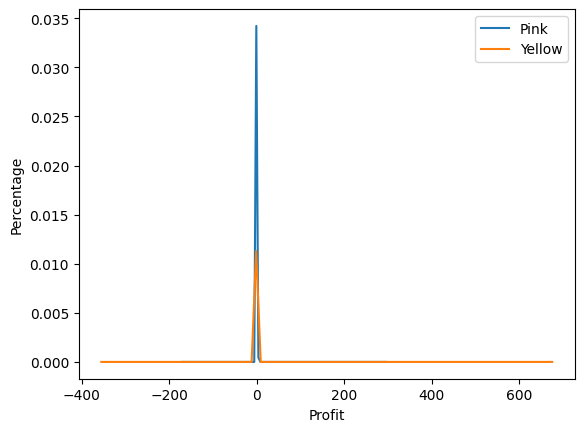

In [220]:
pink_skew = cab_df.loc[cab_df['Company'] == 'Pink Cab']['Profit'].skew()
yellow_skew = cab_df.loc[cab_df['Company'] == 'Yellow Cab']['Profit'].skew()

pink_x = np.linspace(pink_mu - 3*pink_sigma, pink_mu + 3*pink_sigma, 100)
yellow_x = np.linspace(yellow_mu - 3*yellow_sigma, yellow_mu + 3*yellow_sigma, 100)
plt.plot(pink_x, stats.skewnorm.pdf(pink_x, pink_skew))
plt.plot(yellow_x, stats.skewnorm.pdf(yellow_x, yellow_skew))
plt.xlabel('Profit')
plt.ylabel('Percentage')
plt.legend(['Pink', 'Yellow'])
plt.show()

### Remove outliers of extreme profits and losses

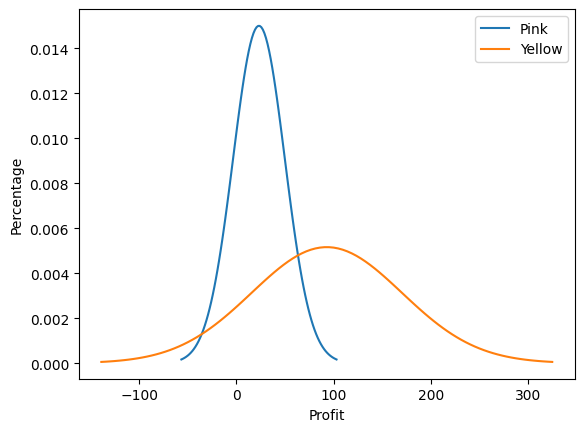

92.95918977318826
23.222468263045034


In [221]:
yellow_mu = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Price Charged'] < yellow_mu + 3*yellow_sigma) & (cab_df['Price Charged'] > yellow_mu - 3*yellow_sigma)]['Profit'].mean()
yellow_sigma = cab_df.loc[(cab_df['Company'] == 'Yellow Cab') & (cab_df['Price Charged'] < yellow_mu + 3*yellow_sigma) & (cab_df['Price Charged'] > yellow_mu - 3*yellow_sigma)]['Profit'].std()
pink_mu = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Price Charged'] < pink_mu + 3*pink_sigma) & (cab_df['Price Charged'] > pink_mu - 3*pink_sigma)]['Profit'].mean()
pink_sigma = cab_df.loc[(cab_df['Company'] == 'Pink Cab') & (cab_df['Price Charged'] < pink_mu + 3*pink_sigma) & (cab_df['Price Charged'] > pink_mu - 3*pink_sigma)]['Profit'].std()

pink_x = np.linspace(pink_mu - 3*pink_sigma, pink_mu + 3*pink_sigma, 100)
yellow_x = np.linspace(yellow_mu - 3*yellow_sigma, yellow_mu + 3*yellow_sigma, 100)
plt.plot(pink_x, stats.norm.pdf(pink_x, pink_mu, pink_sigma), )
plt.plot(yellow_x, stats.norm.pdf(yellow_x, yellow_mu, yellow_sigma))
plt.xlabel('Profit')
plt.ylabel('Percentage')
plt.legend(['Pink', 'Yellow'])
plt.show()

print(yellow_mu)
print(pink_mu)

Accounting for outliers, the mean profit of Pink went down by 63% whereas for Yellow it went down by 42%.

Pink is more dependant on long journies and outlier payments.

## Correlative Analysis

<Axes: title={'center': 'Pink Cab Cost vs KM'}, xlabel='KM Travelled', ylabel='Cost of Trip'>

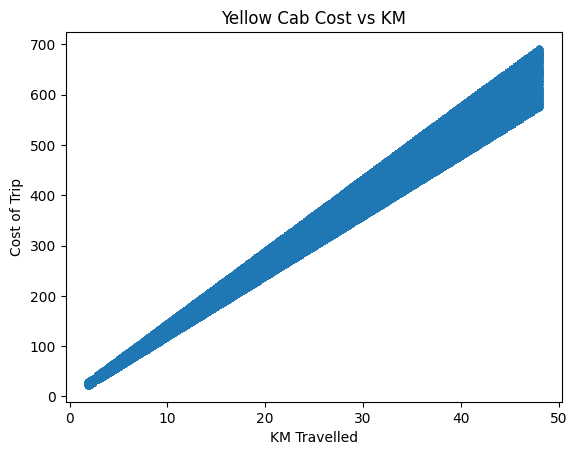

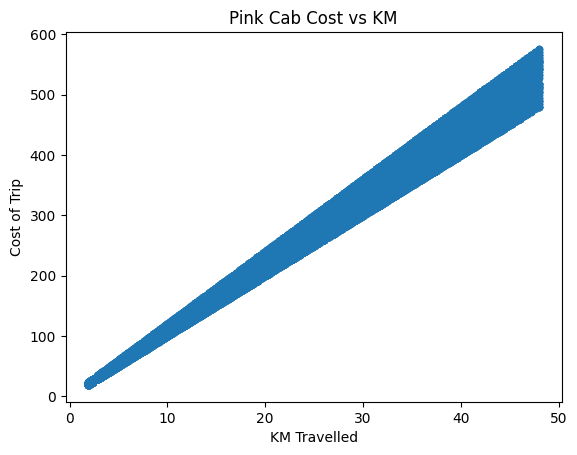

In [222]:
cab_df.loc[cab_df['Company'] == 'Yellow Cab'].plot.scatter(y = 'Cost of Trip', x = 'KM Travelled', title='Yellow Cab Cost vs KM')
cab_df.loc[cab_df['Company'] == 'Pink Cab'].plot.scatter(y = 'Cost of Trip', x = 'KM Travelled', title = 'Pink Cab Cost vs KM')

This graph is quite varied; would like to know durations of trips to account for this.

<Axes: xlabel='KM Travelled', ylabel='Profit'>

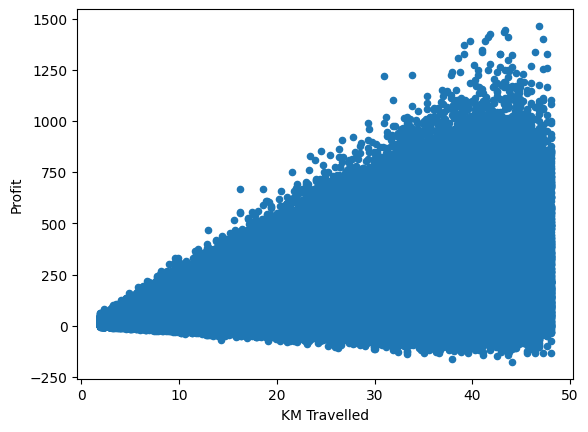

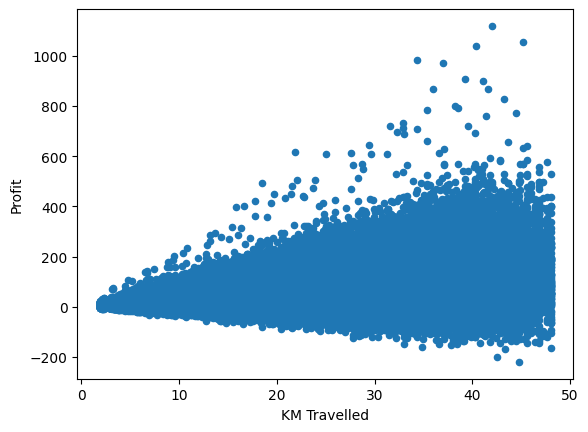

In [223]:
cab_df.loc[cab_df['Company'] == 'Yellow Cab'].plot.scatter(y = 'Profit', x = 'KM Travelled')
cab_df.loc[cab_df['Company'] == 'Pink Cab'].plot.scatter(y = 'Profit', x = 'KM Travelled')

Variance in profit increases by distance, including number of losses

### Yellow Cab Correlations

In [224]:
cab_df.loc[cab_df['Company'] == 'Yellow Cab'].drop(['Company', 'City', 'Transaction ID', 'Date of Travel'], axis=1).corr()

,KM Travelled,Price Charged,Cost of Trip,Profit
KM Travelled,1.000000,0.859709,0.993390,0.503152
Price Charged,0.859709,1.000000,0.853996,0.870485
Cost of Trip,0.993390,0.853996,1.000000,0.487311
Profit,0.503152,0.870485,0.487311,1.000000


### Pink Cab Correlations

In [225]:
cab_df.loc[cab_df['Company'] == 'Pink Cab'].drop(['Company', 'City', 'Transaction ID', 'Date of Travel'], axis=1).corr()

,KM Travelled,Price Charged,Cost of Trip,Profit
KM Travelled,1.000000,0.927765,0.993367,0.442633
Price Charged,0.927765,1.000000,0.921896,0.736791
Cost of Trip,0.993367,0.921896,1.000000,0.417290
Profit,0.442633,0.736791,0.417290,1.000000


Pink has lower efficiency than yellow (Profit to KM, Profit to price charged, profit to cost of trip).

## Customer Retention

In [226]:
users_df = cabtrans_df.groupby(['Customer ID','Company']).size().to_frame(name = 'size').reset_index()
users_df

,Customer ID,Company,size
0,1,Pink Cab,5
1,1,Yellow Cab,22
2,2,Pink Cab,9
3,2,Yellow Cab,24
4,3,Pink Cab,9
...,...,...,...
72204,59998,Yellow Cab,5
72205,59999,Pink Cab,1
72206,59999,Yellow Cab,4
72207,60000,Pink Cab,3


### Unique Customers

,count
Company,
Yellow Cab,36195
Pink Cab,10370


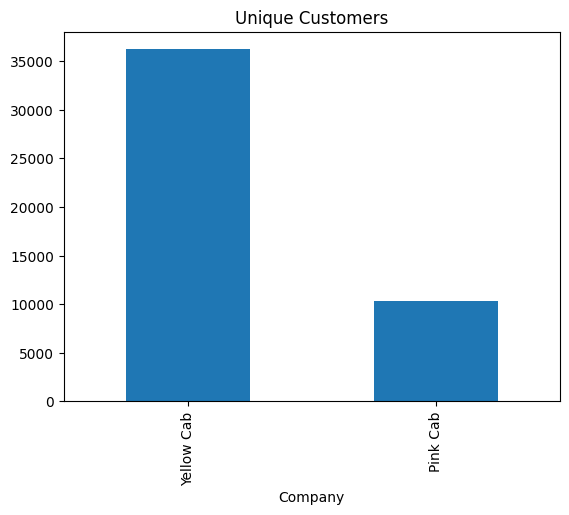

In [227]:
cabtrans_df.drop_duplicates(subset="Customer ID").Company.value_counts().plot(kind="bar", title="Unique Customers")
cabtrans_df.drop_duplicates(subset="Customer ID").Company.value_counts().to_frame()

### 5 or more trips

,count
Company,
Yellow Cab,17141
Pink Cab,4124


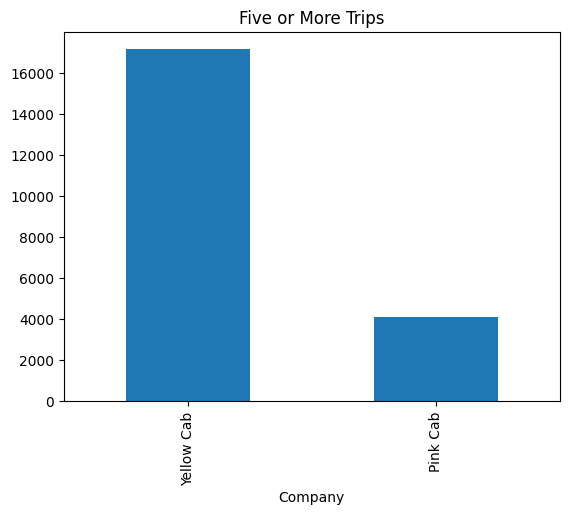

In [228]:
users_df.loc[users_df['size'] > 5]['Company'].value_counts().plot(kind="bar", title="Five or More Trips")
users_df.loc[users_df['size'] > 5]['Company'].value_counts().to_frame()

### 10 or More Trips

,count
Company,
Yellow Cab,10156
Pink Cab,224


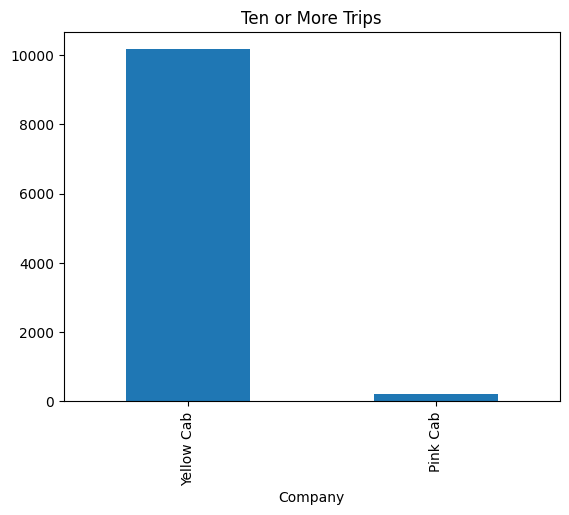

In [229]:
users_df.loc[users_df['size'] > 10]['Company'].value_counts().plot(kind="bar", title="Ten or More Trips")
users_df.loc[users_df['size'] > 10]['Company'].value_counts().to_frame()

### 15 or More Trips

,count
Company,
Yellow Cab,5158
Pink Cab,3


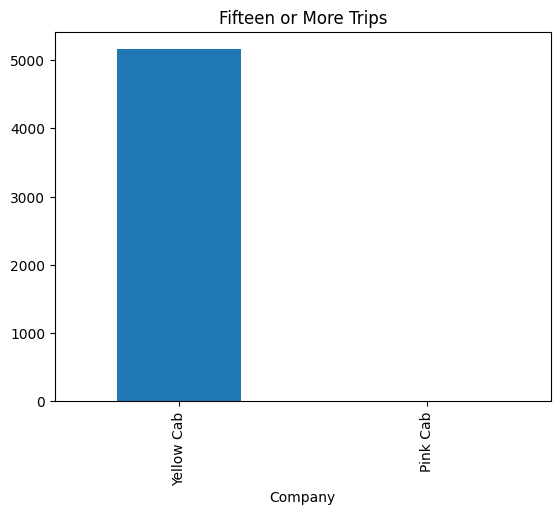

In [230]:
users_df.loc[users_df['size'] > 15]['Company'].value_counts().plot(kind="bar", title="Fifteen or More Trips")
users_df.loc[users_df['size'] > 15]['Company'].value_counts().to_frame()

## Recomendations and Results

Questions (repeated from beginning): 


**1. Is there a correlation between KM traveled and the profit of the trip?**

Yellow Cab has a correlation of 0.5 between profit and distance, while Pink Cab has 0.44. These suggest that there is a moderate correlation between the two. Furthermore, this suggests that Yellow might be charging a higher rate, or a making more money from a waiting fee from traffic and the like, since they are making more profit with larger distances; this cannot be confirmed without knowing the correlation between duration of trip and the profit (perhaps the amount of time taken between trips as well since downtime decreases the amount of total profit generated). 

However, Yellow has a greater correlation between price charged and profit (0.87) as well as cost of trip and profit (0.48) compared to the correlations of Pink Cab (0.73 and 0.41 respectively). This suggests that Yellow Cab has greater efficiency in generating more profit from the money they spend on trips, and are slightly better at spending more money on a trip to make greater profit. In both companies, there is the possibility of restructuring, and changing pricing to increase efficiency. 
   
**2. Is the cab industry growing at a fast enough rate to beat inflation?**
   
According to data analysis done by IBISWorld, the revenue of generated by the Taxi market in the US was $41.7bn in 2022, increasing by 12% from 2021. On average, the industry has grown by 1.5% per year on average between 2017 and 2022, slower than the US economy, which grew 2.06% in 2022 (a real term recession given an expected 8% inflation rate). Although the market will likely grow at a greater rate than average over the next few years (for reasons such as more domestic holidays, higher fuel prices, perhaps), it is likely that accounting for inflation at its current rate, the rising costs of running taxis due to said fuel prices, and that both companies have had a small decrease in profit form 2017 to 2018 followed by a sharp decrease during COVID, there will most likely be short term instability in the industry as a whole. In the long term, the taxi industry will continue to be a staple due to commuters and holidaymakers (this implies it should roughly follow the scope of the economy; for example, people are more likely to go on holidays when the economy is doing well and they have excess spending money).

**3. Do the businesses make a high enough profit margin to remain profitable?**

Yellow Cab makes a profit margin of 48.21% compared to Pink Cab making 21.43%. Due to this, the margins of Yellow Cab are significantly better. This gives Yellow Cab a greater degree of security to endure the market's instability in the recent future. In conjunction with their greater size (at over triple the number of trips made in 2018 compared to Pink Cab), and their vastly superior profit per kilometer ($6.36 compared to $2.36 in 2018), Yellow Cab is both the safer and more profitable choice. 

**4. Are the businesses scalable?**
   
It has already been seen that Yellow Cab is a larger business. The industry as a whole has a small percentage of users in some cities (notably, New York, which has 3.595% of residents using a taxi service). Although this suggests that the industry has lots of opportunity to grow and scale, the competition from cheaper and more informal services such as Uber and allegedly Tesla (who wish to create a service allowing owners to send out their self-driving cars when they are not being used to generate extra income) are squeezing the industry's margins and causing loss in market share. The greatest advantage over more informal services is that taxi drivers might be more trusted, on account of them being licensed, registered, and monitored. Overall, it is difficult to say if the industry is scalable, but the businesses can be scaled by expanding to new cities, particularly one's with less developed public transport systems.  

**5. Do these businesses retain repeat customers?**

In Pink Cab, of the 36k unique customers, around 50% use the service over 5 times, 29% use it over 10 times, and 14% over time 15 times. In Yellow Cab, of the 10k unique customers, around 41% use the service over 5 times, 2% over 10 times, and 0.03% over 15 times. Therefore, the retention of Pink cab is significantly better, suggesting a better brand image, greater trust, and a larger degree of guaranteed business. 

**Final Recommendation**

Therefore, the recommendation is, if choosing to invest, doing so in the Yellow Cab company since it is larger, safer, and more profitable. 